Please make sure you have HOURLY_LOAD-201501.csv downloaded in a folder called hourly_load as well as all the imported Python libraries.

In [49]:
from geopy.geocoders import Nominatim
from retry_requests import retry
import matplotlib.pyplot as plt
import openmeteo_requests
import requests_cache
import pandas as pd
import numpy
import os

In [50]:
def combine_csv_files(folder_path):
    # Initialize an empty list to store dataframes
    all_dataframes = []

    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            
            # Read each CSV file into a dataframe and append it to the list
            df = pd.read_csv(file_path)
            all_dataframes.append(df)

    # Concatenate all dataframes into one
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    return combined_df

In [51]:
folder_path = 'hourly_load/test'
path = os.path.join(os.getcwd(), folder_path)
data = combine_csv_files(folder_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16041 entries, 0 to 16040
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MarketHour  16041 non-null  object 
 1    CSWS       16040 non-null  float64
 2    EDE        16040 non-null  float64
 3    GRDA       16041 non-null  float64
 4    INDN       16040 non-null  float64
 5    KACY       16040 non-null  float64
 6    KCPL       16040 non-null  float64
 7    LES        16040 non-null  float64
 8    MPS        16040 non-null  float64
 9    NPPD       16041 non-null  float64
 10   OKGE       16040 non-null  float64
 11   OPPD       16040 non-null  float64
 12   SECI       16040 non-null  float64
 13   SPRM       16040 non-null  float64
 14   SPS        16040 non-null  float64
 15   WAUE       16040 non-null  float64
 16   WFEC       16040 non-null  float64
 17   WR         16040 non-null  float64
dtypes: float64(17), object(1)
memory usage: 2.2+ MB


In [52]:
data.rename(columns=lambda x: x.strip(), inplace=True)
data.columns

Index(['MarketHour', 'CSWS', 'EDE', 'GRDA', 'INDN', 'KACY', 'KCPL', 'LES',
       'MPS', 'NPPD', 'OKGE', 'OPPD', 'SECI', 'SPRM', 'SPS', 'WAUE', 'WFEC',
       'WR'],
      dtype='object')

In [53]:
data = data[['MarketHour', 'KCPL']]
data.dropna(0, 'any', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16040 entries, 0 to 16040
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MarketHour  16040 non-null  object 
 1   KCPL        16040 non-null  float64
dtypes: float64(1), object(1)
memory usage: 375.9+ KB


C:\Users\xuzha\AppData\Local\Temp\ipykernel_8124\3599064924.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  data.dropna(0, 'any', inplace=True)


In [54]:
data['MarketHour'] = data['MarketHour'].apply(lambda x: x if ' ' in x else x + ' 00:00')
data['DateTime'] = pd.to_datetime(data['MarketHour'])
# If need to use time zone specific datetime: .dt.tz_localize('US/Central', ambiguous='NaT', nonexistent='shift_forward')
data.drop(columns=['MarketHour'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16040 entries, 0 to 16040
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   KCPL      16040 non-null  float64       
 1   DateTime  16040 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 375.9 KB


In [55]:
data['DayOfWeek'] = data['DateTime'].dt.strftime('%A')
# Extract various information
data['Year'] = data['DateTime'].dt.year
data['Quarter'] = data['DateTime'].dt.quarter  # Quarter of the year (1-4)
data['IsWeekend'] = (data['DateTime'].dt.weekday > 5).astype(int)  # 1 if it's a weekend, 0 otherwise
data['Month'] = data['DateTime'].dt.month
data['DayNumber_Year'] = data['DateTime'].dt.day
data['DayNumber_Week'] = data['DateTime'].dt.day_of_week  # Monday is 0, Sunday is 6
#data['DayName'] = data['DateTime'].dt.strftime('%A')  # Full weekday name
data['DayOfYear'] = data['DateTime'].dt.day_of_year
data['Hour'] = data['DateTime'].dt.hour
data['Minute'] = data['DateTime'].dt.minute
data['WeekNumber'] = data['DateTime'].dt.isocalendar().week  # Week number
#data['Second'] = data['DateTime'].dt.second
#data['IsAM'] = data['DateTime'].dt.strftime('%p') == 'AM'  # True if it's AM, False if PM
#data['IsMonthStart'] = data['DateTime'].dt.is_month_start  # True if the day is the start of the month
#data['IsMonthEnd'] = data['DateTime'].dt.is_month_end  

# Displaying the modified DataFrame
print(data.head(20))

        KCPL            DateTime DayOfWeek  Year  Quarter  IsWeekend  Month  \
0   1704.224 2022-01-01 07:00:00  Saturday  2022        1          0      1   
1   1692.773 2022-01-01 08:00:00  Saturday  2022        1          0      1   
2   1688.118 2022-01-01 09:00:00  Saturday  2022        1          0      1   
3   1703.409 2022-01-01 10:00:00  Saturday  2022        1          0      1   
4   1738.430 2022-01-01 11:00:00  Saturday  2022        1          0      1   
5   1794.696 2022-01-01 12:00:00  Saturday  2022        1          0      1   
6   1872.026 2022-01-01 13:00:00  Saturday  2022        1          0      1   
7   1957.145 2022-01-01 14:00:00  Saturday  2022        1          0      1   
8   2031.734 2022-01-01 15:00:00  Saturday  2022        1          0      1   
9   2125.506 2022-01-01 16:00:00  Saturday  2022        1          0      1   
10  2203.754 2022-01-01 17:00:00  Saturday  2022        1          0      1   
11  2269.740 2022-01-01 18:00:00  Saturday  2022    

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16040 entries, 0 to 16040
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   KCPL            16040 non-null  float64       
 1   DateTime        16040 non-null  datetime64[ns]
 2   DayOfWeek       16040 non-null  object        
 3   Year            16040 non-null  int64         
 4   Quarter         16040 non-null  int64         
 5   IsWeekend       16040 non-null  int32         
 6   Month           16040 non-null  int64         
 7   DayNumber_Year  16040 non-null  int64         
 8   DayNumber_Week  16040 non-null  int64         
 9   DayOfYear       16040 non-null  int64         
 10  Hour            16040 non-null  int64         
 11  Minute          16040 non-null  int64         
 12  WeekNumber      16040 non-null  UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(1), int32(1), int64(8), object(1)
memory usage: 1.6+ MB


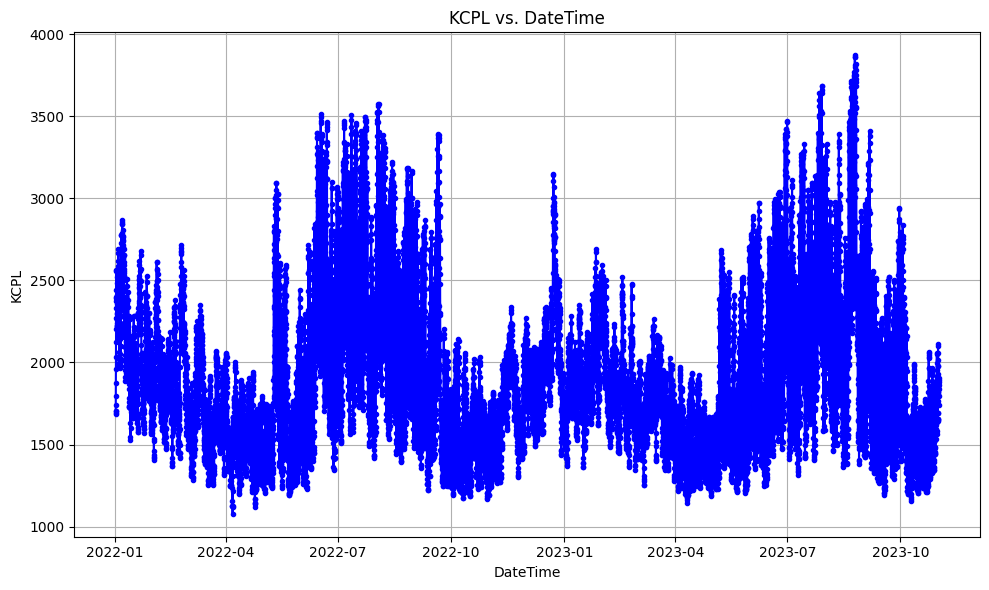

In [57]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(data['DateTime'], data['KCPL'], marker='.', linestyle='-', color='b')
plt.title('KCPL vs. DateTime')
plt.xlabel('DateTime')
plt.ylabel('KCPL')
plt.grid(True)
plt.tight_layout()

plt.show()

In [58]:
# This block of code for extracting lat and long of Kansas City was not working. 
# geolocator = Nominatim(user_agent='city_coordinates')
# city_name = 'Kansas City'
# location = geolocator.geocode(city_name)

# if location:
#     latitude = location.latitude
#     longitude = location.longitude
#     print(f"Coordinates for {city_name}: Latitude {latitude}, Longitude {longitude}")
# else:
#     print(f"Coordinates for {city_name} not found.")

In [59]:
start_date = data['DateTime'].iloc[0].strftime('%Y-%m-%d')
end_date = data['DateTime'].iloc[-1].strftime('%Y-%m-%d')
print(f"Start date of current batch: {start_date}\nEnd date of current batch: {end_date}")

Start date of current batch: 2022-01-01
End date of current batch: 2023-11-01


In [60]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

latitude = 39.0997
longitude = 94.5786

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": latitude,
	"longitude": longitude,
	"start_date": start_date,
	"end_date": end_date,
	"hourly": ["temperature_2m", "weather_code"],
	"temperature_unit": "fahrenheit",
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_weather_code = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s"),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_f"] = hourly_temperature_2m
hourly_data["weather_code"] = hourly_weather_code.astype(int)

hourly_dataframe = pd.DataFrame(data = hourly_data)
hourly_dataframe.head(10)

,date,temperature_f,weather_code
0,2021-12-31 16:00:00,13.603100,0
1,2021-12-31 17:00:00,11.623098,0
2,2021-12-31 18:00:00,6.943100,0
3,2021-12-31 19:00:00,5.683100,0
4,2021-12-31 20:00:00,6.133099,0
5,2021-12-31 21:00:00,9.733101,1
6,2021-12-31 22:00:00,11.803101,1
7,2021-12-31 23:00:00,12.343100,0
8,2022-01-01 00:00:00,10.453100,2
9,2022-01-01 01:00:00,9.733101,3


In [61]:
hourly_dataframe['weather_code'].value_counts()

0     8075
1     2909
2     2315
3     2204
51     272
71     191
73      48
53      39
61      11
55      10
75       4
63       2
Name: weather_code, dtype: int64

In [62]:
# Merge DataFrames on 'MarketHour' and 'date'
merged_df = pd.merge(data, hourly_dataframe, left_on='DateTime', right_on='date', how='inner')

# Drop the duplicate 'date' column
merged_df.drop(columns=['date'], inplace=True)

# Now, 'merged_df' contains the merged data
merged_df.head(10)

,KCPL,DateTime,DayOfWeek,Year,Quarter,IsWeekend,Month,DayNumber_Year,DayNumber_Week,DayOfYear,Hour,Minute,WeekNumber,temperature_f,weather_code
0,1704.224,2022-01-01 07:00:00,Saturday,2022,1,0,1,1,5,1,7,0,52,14.773098,2
1,1692.773,2022-01-01 08:00:00,Saturday,2022,1,0,1,1,5,1,8,0,52,14.683102,2
2,1688.118,2022-01-01 09:00:00,Saturday,2022,1,0,1,1,5,1,9,0,52,14.773098,2
3,1703.409,2022-01-01 10:00:00,Saturday,2022,1,0,1,1,5,1,10,0,52,12.703100,2
4,1738.430,2022-01-01 11:00:00,Saturday,2022,1,0,1,1,5,1,11,0,52,12.343100,2
5,1794.696,2022-01-01 12:00:00,Saturday,2022,1,0,1,1,5,1,12,0,52,10.093100,2
6,1872.026,2022-01-01 13:00:00,Saturday,2022,1,0,1,1,5,1,13,0,52,8.833101,3
7,1957.145,2022-01-01 14:00:00,Saturday,2022,1,0,1,1,5,1,14,0,52,14.773098,3
8,2031.734,2022-01-01 15:00:00,Saturday,2022,1,0,1,1,5,1,15,0,52,11.083101,2
9,2125.506,2022-01-01 16:00:00,Saturday,2022,1,0,1,1,5,1,16,0,52,13.693100,2


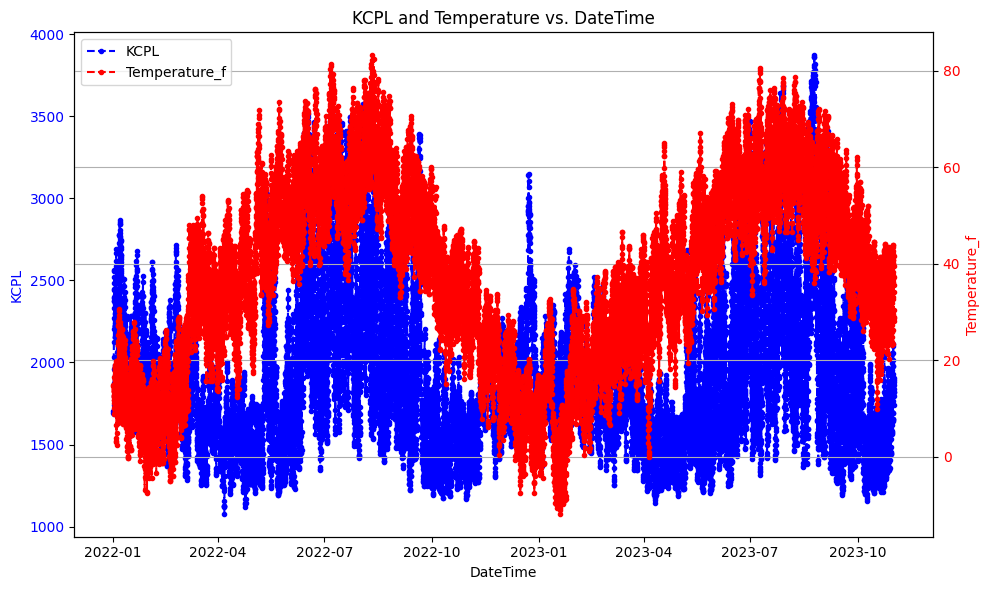

In [63]:
x = merged_df['DateTime']
y_kcpl = merged_df['KCPL']
y_temperature = merged_df['temperature_f']

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot 'KCPL' data using the first y-axis (left)
ax1.plot(x, y_kcpl, marker='.', linestyle='--', color='b', label='KCPL')
ax1.set_xlabel('DateTime')
ax1.set_ylabel('KCPL', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis on the right for 'temperature_2m'
ax2 = ax1.twinx()
ax2.plot(x, y_temperature, marker='.', linestyle='--', color='r', label='Temperature_f')
ax2.set_ylabel('Temperature_f', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.xlabel('DateTime')
plt.grid(True)
plt.xticks(rotation=45)

# Set a title
plt.title('KCPL and Temperature vs. DateTime')

# Show the plot
plt.tight_layout()
plt.show()

In [64]:
merged_df['DateTime'].iloc[0].strftime('%Y') + '_' + merged_df['DateTime'].iloc[-1].strftime('%Y')

'2022_2023'

In [65]:
batch_year = merged_df['DateTime'].iloc[0].strftime('%Y') + '_' + merged_df['DateTime'].iloc[-1].strftime('%Y')
folder_name = 'dataset/test'
file_name = batch_year + '.csv'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
file_path = os.path.join(folder_name, file_name)
merged_df.to_csv(file_path, index=False)
print(f"CSV file '{file_name}' saved in the {folder_name} folder.")

CSV file '2022_2023.csv' saved in the dataset/test folder.
